In [2]:
# ─────────────────────────────────────────────
# 1 : Librairies
# ─────────────────────────────────────────────

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import polars as pl
from scipy.optimize import curve_fit
from tls.probabilities import proba_gamma

popt [mu, theta, A]: [37.89810256 17.99604862  0.92443102]


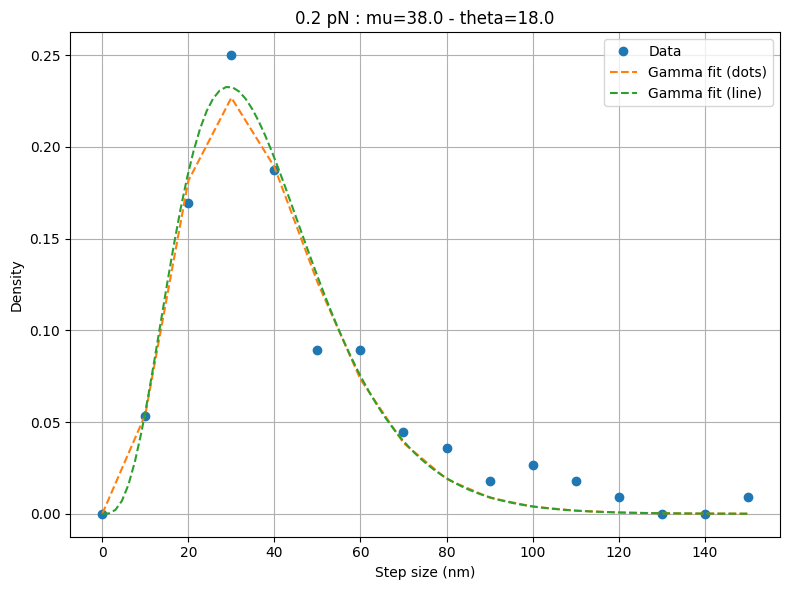

In [4]:
# ─────────────────────────────────────────────
# 2.1 : Ryu Datas
# ─────────────────────────────────────────────

# Datas
data = np.array([1, 0, 0, 1, 2, 3, 2, 4, 5, 10, 10, 21, 28, 19, 6, 0])
y_data = data[::-1] / np.sum(data)
x_data = np.arange(0, 150 + 1, 10).astype(float)
x_safe = x_data.copy()
x_safe[0] = 1e-6

# Filtering
def proba_gamma_fit_counts(x, mu, theta, A):
    y = proba_gamma(mu, theta, x)
    y = np.where(np.isfinite(y), y, 0.0)
    return A * y

# First guesses
A0 = float(y_data.sum())
mu0, theta0 = 30.0, 20.0

# Fitting
popt, pcov = curve_fit(
    proba_gamma_fit_counts,
    x_safe,
    y_data,
    p0=[mu0, theta0, A0],
    bounds=([1e-6, 1e-6, 1e-6], [np.inf, np.inf, np.inf]),
)
print("popt [mu, theta, A]:", popt)

# Fine curve
x_step = 100
x_fine = np.linspace(x_data.min(), x_data.max(), x_step)
y_fine = proba_gamma(popt[0], popt[1], x_fine)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_data, y_data, 'o', label="Data")
plt.plot(x_data, proba_gamma_fit_counts(x_safe, *popt), '--', label="Gamma fit (dots)")
plt.plot(x_fine, y_fine*x_step/len(x_data), '--', label="Gamma fit (line)")
plt.title(f"0.2 pN : mu={np.round(popt[0])} - theta={np.round(popt[1])}")
plt.xlabel("Step size (nm)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 mu_ryu_bp = 182.0 
 theta_ryu_bp = 91.0

 mu_nm = 60 
 theta_nm = 30


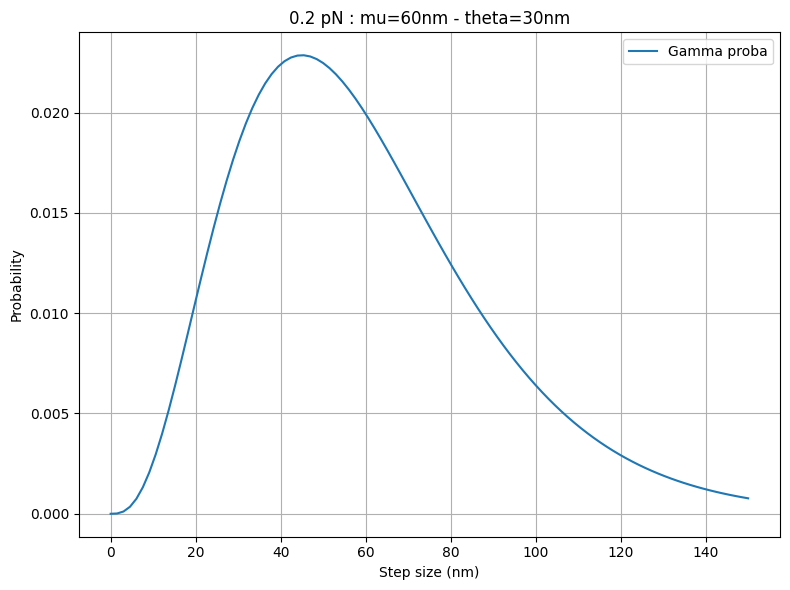

In [5]:
# ─────────────────────────────────────────────
# 2.2 : Conversions
# ─────────────────────────────────────────────

# From nm_in_ryu to bp_in_ryu
mu_ryu_nm = 40     # nm Ryu
theta_ryu_nm = 20  # nm Ryu
ryu_nm_per_bp = 0.220
mu_ryu_bp = mu_ryu_nm / ryu_nm_per_bp
theta_ryu_bp = theta_ryu_nm / ryu_nm_per_bp
print(f"\n mu_ryu_bp = {np.round(mu_ryu_bp)} \n theta_ryu_bp = {np.round(theta_ryu_bp)}")

# From bp_in_ryu to nm
bp_per_nm = 3
mu_nm = int(mu_ryu_bp / bp_per_nm)
theta_nm = int(theta_ryu_bp / bp_per_nm)
print(f"\n mu_nm = {np.round(mu_nm)} \n theta_nm = {np.round(theta_nm)}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_fine, proba_gamma(mu_nm, theta_nm, x_fine), '-', label="Gamma proba")
plt.title(f"0.2 pN : mu={mu_nm}nm - theta={theta_nm}nm")
plt.xlabel("Step size (nm)")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

l (entier) : [100  83  70  59  50  43  37  32  28  24  20  17  14  12  10   8   6   4
   2   1]
d après arrondi l : [0.00740741 0.00847458 0.00952381 0.0106383  0.01176471 0.01282051
 0.01388889 0.01492537 0.01587302 0.01694915 0.01818182 0.01923077
 0.02040816 0.0212766  0.02222222 0.02325581 0.02439024 0.02564103
 0.02702703 0.02777778]


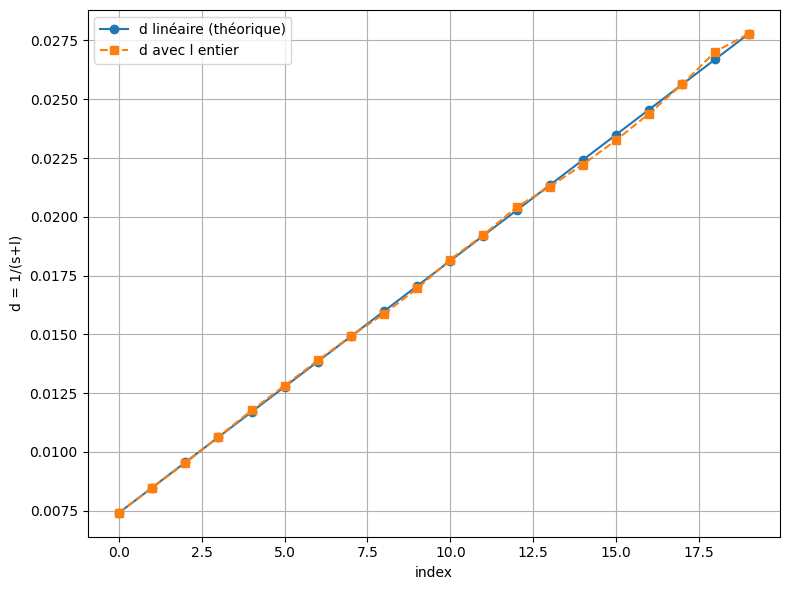

In [ ]:
# ─────────────────────────────────────────────
# 2.3 : Linker size Generation 
# ─────────────────────────────────────────────

# Values
s = 35
N = 20
Lmin, Lmax = 1, 100  # bornes souhaitées pour l (entières)
d = np.linspace(1/(s+Lmax), 1/(s+Lmin), N)
l = 1/d - s
l_int = np.rint(l).astype(int)  # arrondi au plus proche
d_int = 1/(s + l_int)           # d correspondant après arrondi

# Prints
# print("d linéaire :", d)
# print("l (float)  :", l)
print("l (entier) :", l_int)
print("d après arrondi l :", d_int)

# Plot
plt.figure(figsize=(8,6))
plt.plot(d, 'o-', label="d linéaire (théorique)")
plt.plot(d_int, 's--', label="d avec l entier")
plt.xlabel("index")
plt.ylabel("d = 1/(s+l)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [92]:
# ─────────────────────────────────────────────
# 3.1 : Getting Datas from Generation
# ─────────────────────────────────────────────

# DataFrame
root = Path("/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-10-23_PC/nucleo_access_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]
df_merged = pl.scan_parquet(paths).collect()
df_sorted = df_merged.sort(by="l", descending=False)

# Prints
# print(df_sorted.head)
print(df_sorted.columns)

# Getting Values : Inputs
alpha_choice    = df_sorted["alpha_choice"].to_list()[0]
mu              = df_sorted["mu"].to_numpy()[0]
th              = df_sorted["theta"].to_numpy()[0]
s               = df_sorted["s"].to_numpy()[0]
l               = df_sorted["l"].to_numpy()
Lmin            = df_sorted["Lmin"].to_numpy()[0]
Lmax            = df_sorted["Lmax"].to_numpy()[0]
bps             = df_sorted["bps"].to_numpy()[0]
tmax            = df_sorted["tmax"].to_numpy()[0]
dt              = df_sorted["dt"].to_numpy()[0]

# Getting Values : Inputs
results         = df_sorted["results"].to_numpy()
results_mean    = df_sorted["results_mean"].to_numpy()
v_mean          = df_sorted["v_mean"].to_numpy()
vi_med          = df_sorted["vi_med"].to_numpy()
wf              = df_sorted["wf"].to_numpy()


# Calculating Values
d               = 1 / (s + l)
v_th            = mu * d * l
ratio           = v_mean / v_th

# Arrays for plots
chromatin       = np.arange(Lmin, Lmax, bps)
time            = np.arange(0, tmax, dt)

['alpha_choice', 's', 'l', 'bpmin', 'mu', 'theta', 'alphao', 'alphaf', 'beta', 'lmbda', 'rtot_bind', 'rtot_rest', 'Lmin', 'Lmax', 'bps', 'origin', 'tmax', 'dt', 'nt', 'alpha_mean', 'obs_points', 'obs_distrib', 'link_points', 'link_distrib', 'link_view', 'results', 'results_mean', 'results_med', 'results_std', 'v_mean', 'v_med', 'vf', 'Cf', 'wf', 'vf_std', 'Cf_std', 'wf_std', 'xbj_points', 'xbj_distrib', 'tbj_points', 'tbj_distrib', 'bin_fpt', 'fpt_distrib_2D', 'fpt_number', 'dx_points', 'dx_distrib', 'dx_mean', 'dx_med', 'dx_mp', 'dt_points', 'dt_distrib', 'dt_mean', 'dt_med', 'dt_mp', 'vi_points', 'vi_distrib', 'vi_mean', 'vi_med', 'vi_mp', 'alpha_0', 'xt_over_t', 'G', 'bound_low', 'bound_high']


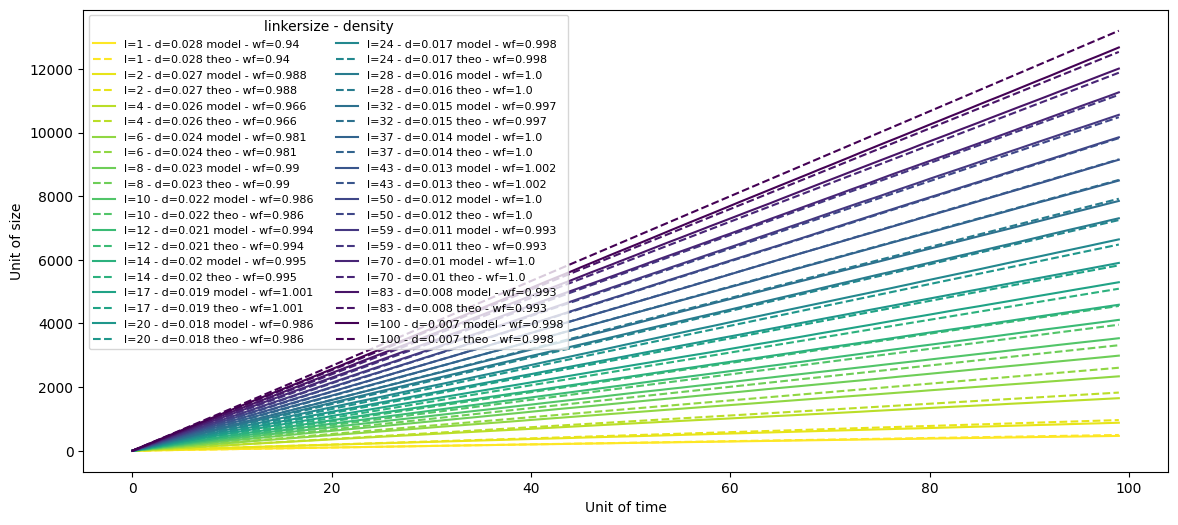

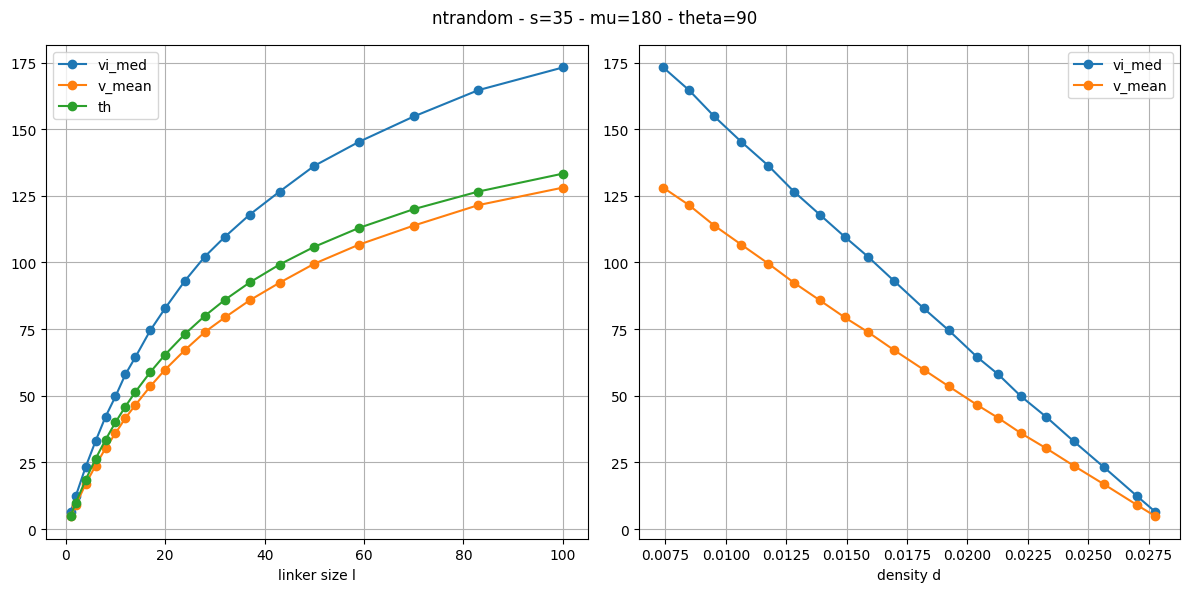

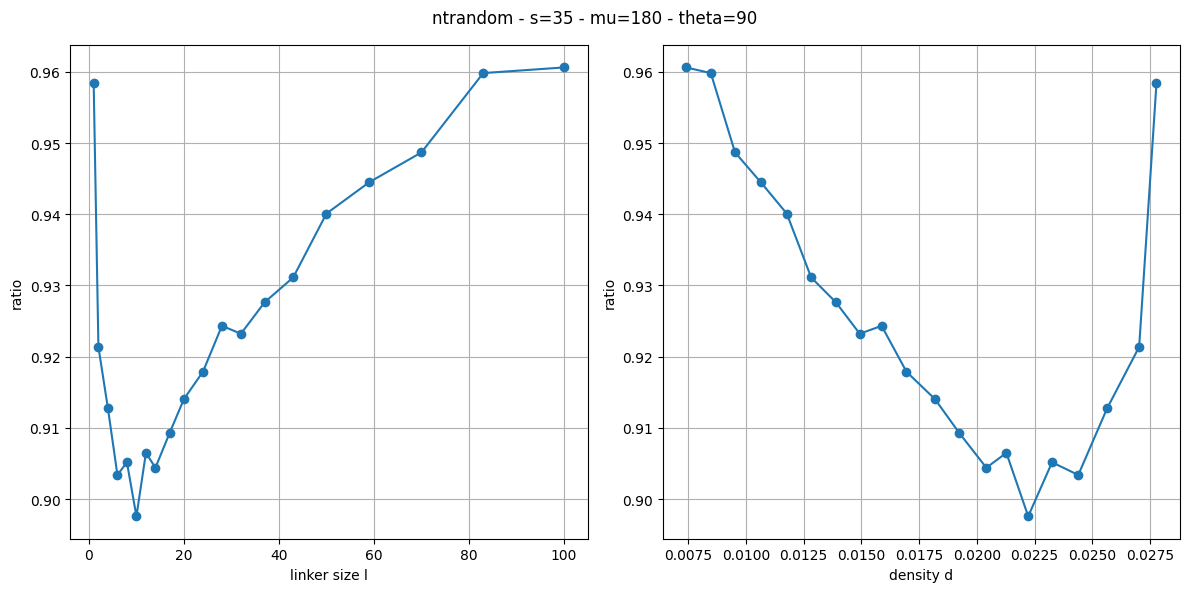

In [101]:
# ─────────────────────────────────────────────
# 3.2 : Plots
# ─────────────────────────────────────────────

# Plot : Few trajectories
plt.figure(figsize=(14,6))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(d), vmax=max(d))
for rm_array, l_val, d_val, v_th_val, wf_val in zip(results_mean, l, d, v_th, wf):
    color = cmap(norm(d_val))
    plt.plot(time, rm_array, label=f"l={l_val} - d={np.round(d_val,3)} model - wf={wf_val}", ls="-", color=color)
    plt.plot(time, time * v_th_val, label=f"l={l_val} - d={np.round(d_val,3)} theo - wf={wf_val}", ls="--", color=color)
plt.xlabel("Unit of time")
plt.ylabel("Unit of size")
plt.legend(title="linkersize - density", ncol=2, fontsize=8)
plt.show()

# Subplot : v_mean and vi_med
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.suptitle(f"{alpha_choice} - s={s} - mu={mu} - theta={th}")
axs[0].plot(l, vi_med, label="vi_med", marker="o")
axs[0].plot(l, v_mean, label="v_mean", marker="o")
axs[0].plot(l, mu*l/(l+s), label="th", marker="o")
axs[0].set_xlabel("linker size l")
axs[0].grid(True, which="both")
axs[0].legend()
# axs[0].loglog(False)
axs[1].plot(d, vi_med, label="vi_med", marker="o")
axs[1].plot(d, v_mean, label="v_mean", marker="o")
axs[1].set_xlabel("density d")
axs[1].grid(True, which="both")
# axs[1].loglog(False)
axs[1].legend()
plt.tight_layout()
plt.show()

# Subplot : ratio of v_th and v_model
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle(f"{alpha_choice} - s={s} - mu={mu} - theta={th}")
axes[0].plot(l, ratio, marker='o')
axes[0].set_xlabel("linker size l")
axes[0].set_ylabel("ratio")
axes[0].grid(True, which="both")
axes[1].plot(d, ratio, marker='o')
axes[1].set_xlabel("density d")
axes[1].set_ylabel("ratio")
axes[1].grid(True, which="both")
plt.tight_layout()
plt.show()

# .